In [11]:
import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [12]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import cobra
from molmass import Formula
from cobra.io import read_sbml_model
from experiments.fast_dFBA import MichaelisMentenBounds, dFBA
from utils.cobra_utils import get_or_create_exchange
from utils.utils import pp
from parameters.drawdown import *
from plotting.diagnostic import uptakes_and_secretions, plot_pathway, plot_metabolite_fluxes

In [13]:
MODEL_FILE = "../model/Rpom_05_hwa.xml"
BIOMASS_ID = "RPOM_provisional_biomass"
DATA_FILE = "../data/clean/CUE/cue_data.csv"

# Load data
data = pd.read_csv(DATA_FILE)

# Load and set up model
model = read_sbml_model(MODEL_FILE)

# Set up Michaelis-Menten medium
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# Get V_maxes
V_max_glc = 10 * abs(float(ex_glc._annotation["Experimental rate"]))
V_max_ace = 10 * abs(float(ex_ace._annotation["Experimental rate"]))

dynamic_medium = {
    ex_glc: MichaelisMentenBounds("Glucose[e]", V_max_glc, K_M.to("mM").magnitude),
    ex_ace: MichaelisMentenBounds(
        "ACET[e]", V_max_ace, K_M.to("mM").magnitude)
}

# Initial state
initial_conditions = data[["Initial_mM_Glucose",
                            "Initial_mM_Acetate"]].drop_duplicates().values

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'2.0 mM Glucose, 0.0 mM Acetate'}, ylabel='flux (mg / hr)'>)

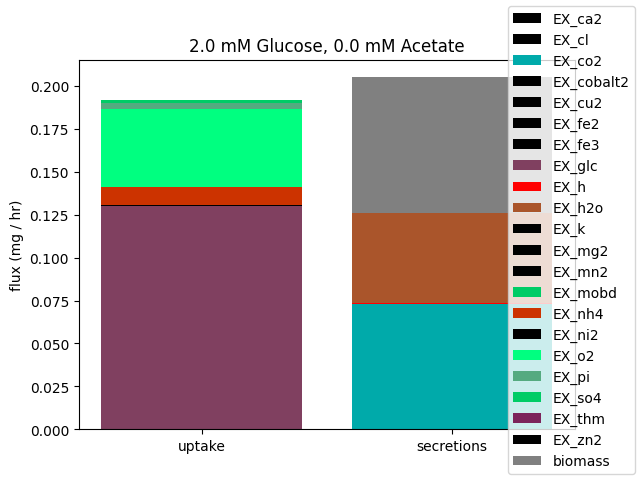

In [14]:
initial_glucose, initial_acetate = initial_conditions[3, :]

initial_biomass = (data[(data["Type"] == "counts") &
                        (data["Time (h)"] == 0) &
                        (data["Initial_mM_Glucose"] == initial_glucose) &
                        (data["Initial_mM_Acetate"] == initial_acetate)
                        ]["Value"].mean() * (1/u.mL) * MASS_PER_CELL).to("g/L").magnitude
tmax = (data[(data["Type"] == "counts") & (data["Initial_mM_Glucose"] == initial_glucose) & (
    data["Initial_mM_Acetate"] == initial_acetate)]["Time (h)"].max())

substrates = {
    "Glucose[e]" : initial_glucose,
    "ACET[e]": initial_acetate
}

with model:
    for exchange, bounds in dynamic_medium.items():
        bounds.bound(exchange, substrates[bounds.substrate_id])
    sol = model.optimize()

boundary_ids = [rxn.id for rxn in model.boundary]
boundary_fluxes = sol.fluxes[boundary_ids].reset_index()
boundary_fluxes["fluxes"] = boundary_fluxes["fluxes"] * initial_biomass * CUE_VOLUME.to("L").magnitude  # convert to mmol/hr
boundary_fluxes["Secreting"] = ((np.array([bool(rxn.reactants) for rxn in model.boundary]) & (boundary_fluxes["fluxes"] > 0))
                                | (np.array([bool(rxn.products) for rxn in model.boundary]) & (boundary_fluxes["fluxes"] < 0)))
boundary_fluxes["Mol mass"] = [Formula(list(rxn.metabolites.keys())[0].formula).mass for rxn in model.boundary]

uptakes_and_secretions(model, boundary_fluxes, sol, initial_biomass, CUE_VOLUME, initial_glucose, initial_acetate)

In [6]:
from plotting.production_networks import *

plot_network_as_plotly(
    layout_production_subgraph(
        production_paths(
            active_graph(model),
            ["EX_glc"],
            ["ARG[c]"]
        ),
        ["EX_glc"]
    )
)